# 序列到序列学习

```{note}
本节中，我们将使用两个循环神经网络作为编码器和解码器，将其应用于机器翻译的序列到序列学习。
```

## 结构

我们要实现的模型结构如下图所示：

![jupyter](../images/9/seq2seq_1.svg)

在训练时，我们使用`<bos>`+真实输出序列作为解码器的输入，即teacher-forcing。

预测时，解码器当前时间步的输入都将来自于前一时间步的输出词元。

我们当然也可以使用多层RNN，示意图如下：

![jupyter](../images/9/seq2seq-details.svg)

## 编码器

In [1]:
import torch
from torch import nn
import d2l


class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的RNN编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
                 dropout=0):
        super(Seq2SeqEncoder, self).__init__()
        # 先要使用Embedding把one-hot转为dense
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 从 (`batch_size`, `num_steps`) 转为 (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned in self.rnn, it defaults to zeros
        output, state = self.rnn(X)
        # shape of output: (`num_steps`, `batch_size`, `num_hiddens`)
        # shape of state: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

## 解码器

In [2]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的RNN解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super(Seq2SeqDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 解码器每步还会接受编码器的最终state作为输入的一部分
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        # 输出层
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # transform to (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播编码器的最终state
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # shape of output: (`batch_size`, `num_steps`, `vocab_size`)
        # shape of state: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

## 训练

In [3]:
# 获取数据
batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [4]:
# 创建模型
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                         dropout)
net = d2l.EncoderDecoder(encoder, decoder)

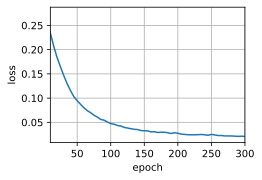

In [5]:
# 训练
lr, num_epochs = 0.005, 300
d2l.train_nmt(net, train_iter, lr, num_epochs, tgt_vocab)

In [6]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# 预测并使用BLEU评估
for eng, fra in zip(engs, fras):
    translation = d2l.predict_nmt(net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est du <unk> !, bleu 0.447
i'm home . => je suis chez moi ., bleu 1.000
